C:\Users\shiva\AppData\Local\Temp\ipykernel_22192\3710165112.py:265: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Blood Pressure (mm Hg)'] = X['Blood Pressure (mm Hg)'].apply(lambda x: int(x.split('/')[0]))  # Convert to numerical


Enter 'single' for single analysis or 'collective' for collective analysis:  single


C:\Users\shiva\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\shiva\AppData\Local\Temp\ipykernel_22192\3710165112.py:160: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics, y=values, palette='viridis')


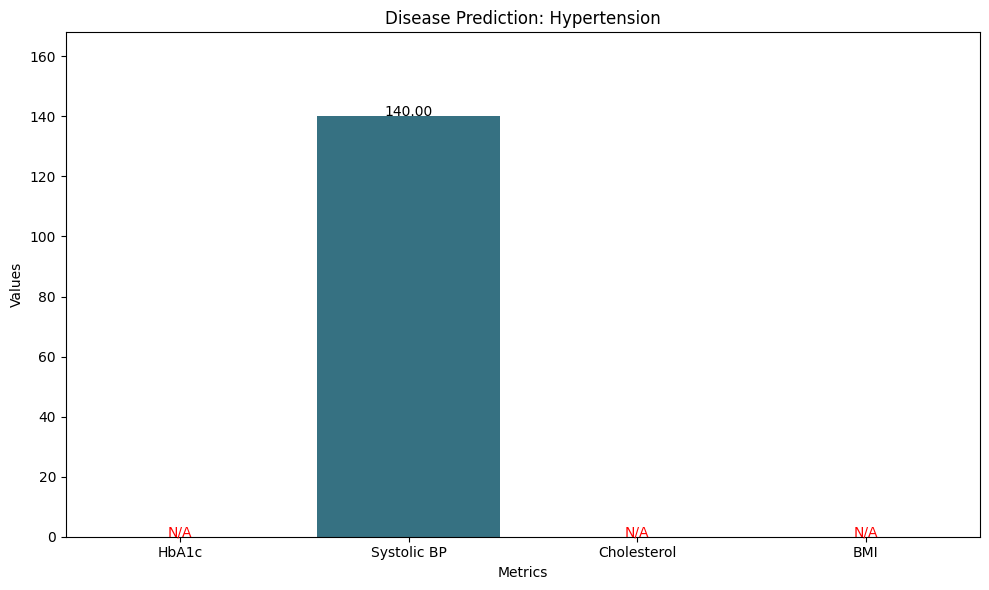


Recommendations:
- Reduce salt intake, exercise regularly, and monitor blood pressure levels.

Observations:
- High blood pressure indicates advanced hypertension.
- Take Prescribed hypertension medication.
Consult your doctor for further analysis and helping you


In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pytesseract
from PIL import Image
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from datetime import datetime

pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'


def extract_text_from_image(image_path):
    image = Image.open(image_path)
    text = pytesseract.image_to_string(image)
    return text

def preprocess_lab_data(text):
    text = text.lower().replace('\n', ' ').strip()
    
    lab_data = {}
    if 'date: ' in text:
        date_str = text.split('date: ')[1].split(' ')[0].strip()
        lab_data['Date'] = datetime.strptime(date_str, '%Y-%m-%d')
    else:
        lab_data['Date'] = None
    
    if 'hba1c: ' in text:
        try:
            lab_data['HbA1c'] = float(text.split('hba1c: ')[1].split('%')[0].strip())
        except ValueError:
            lab_data['HbA1c']=None
    else:
        lab_data['HbA1c'] = None
    
    if 'blood pressure: ' in text:
        try:
            lab_data['BloodPressure'] = text.split('blood pressure: ')[1].split('/')[0] + '/' + text.split('blood pressure: ')[1].split('/')[1].split(' ')[0].strip()
        except ValueError:
            lab_data['BloodPressure']=None
    else:
        lab_data['BloodPressure'] = None
    
    if 'cholesterol: ' in text:
        try:
            lab_data['Cholesterol'] = int(text.split('cholesterol: ')[1].split(' ')[0].strip())
        except ValueError:
            lab_data['Cholesterol']=None
    else:
        lab_data['Cholesterol'] = None
    
    if 'bmi: ' in text:
        lab_data['BMI'] = float(text.split('bmi: ')[1].split(' ')[0].strip())
    else:
        lab_data['BMI'] = None
    
    return lab_data

    

# Function to analyze single patient data
def analyze_patient_data(lab_data, model):
    features = [lab_data['HbA1c'], int(lab_data['BloodPressure'].split('/')[0]), lab_data['Cholesterol'], lab_data['BMI']]
    prediction = model.predict([features])[0]
    recommendations = []
    observations = []
    
    if prediction == 'Diabetes':
        recommendations.append("Maintain a healthy diet, exercise regularly, and monitor blood sugar levels.")
        if lab_data['HbA1c'] >= 6.5:
            observations.append("High HbA1c indicates confirmed diabetes.")
            recommendations.append("May consider a retinoscopy and KFT."  )
        elif lab['HbA1c']>=5.7 and lab_data['HbA1c']<=6.5:
            observations.append("pre-diabetic stage")
        else:
            observations.append("Not a high range, still be careful")
        observations.append("Take Prescribed diabetes medication.")

    if prediction == 'Hypertension':
        recommendations.append("Reduce salt intake, exercise regularly, and monitor blood pressure levels.")
        if int(lab_data['BloodPressure'].split('/')[0]) >= 140:
            observations.append("High blood pressure indicates advanced hypertension.")
        else:
            observations.append("Moderate blood pressure levels indicate controlled hypertension.")
        observations.append("Take Prescribed hypertension medication.")
    
    if prediction == 'Both':
        recommendations.append("Follow a balanced diet, exercise regularly, and monitor both blood pressure and blood sugar levels.")
        if lab_data['HbA1c'] >= 6.5 and int(lab_data['BloodPressure'].split('/')[0]) >= 140:
            observations.append("Signs of both confirmed diabetes and hypertension detected.")
        else:
            observations.append("Signs of both moderate diabetes and hypertension detected.")
        observations.append("Take Prescribed hypertension medication.")
    if prediction == 'None':
        recommendations.append("Maintain a healthy lifestyle to prevent chronic diseases.")
        observations.append("No chronic diseases detected. You are Healthy")
    
    return prediction, recommendations, observations

# Function to analyze collective patient data
def analyze_collective_data(lab_reports, model):
    all_lab_data = []
    for report in lab_reports:
        lab_report_text = extract_text_from_image(report)
        lab_data= preprocess_lab_data(lab_report_text)
        all_lab_data.append(lab_data)
    all_lab_data.sort(key=lambda x: x['Date'] if x['Date'] else datetime.min)
    
        
    trends = {
    'Date': [data['Date'].strftime('%Y-%m-%d') if data['Date'] else 'Unknown' for data in all_lab_data],
    'HbA1c': [data['HbA1c'] for data in all_lab_data],
    'BloodPressure': [int(data['BloodPressure'].split('/')[0]) if data['BloodPressure'] is not None else None for data in all_lab_data],
    'Cholesterol': [data['Cholesterol'] if data['Cholesterol'] is not None else 0 for data in all_lab_data],
    'BMI': [data['BMI'] if data['BMI'] is not None else 0 for data in all_lab_data]
    }

    
    trends_analysis = {}
    for key, values in trends.items():
        trend_result = []
        for i in range(1, len(values)):
            if values[i] is None or values[i - 1] is None:
                trend_result.append("unkonwn")
            elif values[i] > values[i-1]:
                trend_result.append("increasing")
            elif values[i] < values[i - 1]:
                trend_result.append("decreasing")
            else:
                trend_result.append("constant")
        trends_analysis[key] = trend_result
    
    # Analyze the last report for the current disease state
    current_lab_data = all_lab_data[-1]
    current_prediction, current_recommendations, current_observations = analyze_patient_data(current_lab_data, model)

    return trends, trends_analysis, current_prediction, current_recommendations, current_observations

    
# Function to visualize single analysis


def visualize_single_analysis(lab_data, disease, recommendations, observations):
    # Extract lab data values
    metrics = ['HbA1c', 'Systolic BP', 'Cholesterol', 'BMI']
    values = [
        lab_data.get('HbA1c'),
        int(lab_data['BloodPressure'].split('/')[0]) if lab_data['BloodPressure'] else None,
        lab_data.get('Cholesterol'),
        lab_data.get('BMI')
    ]

    # Remove None values for visualization
    valid_values = [value for value in values if value is not None]

    # Set up barplot
    plt.figure(figsize=(10, 6))
    sns.barplot(x=metrics, y=values, palette='viridis')

    plt.title(f'Disease Prediction: {disease}')
    plt.ylabel('Values')
    plt.xlabel('Metrics')
    plt.ylim(0, max(valid_values) * 1.2 if valid_values else 10)  # Handle empty or None values gracefully

    # Annotate bars with values
    for i, value in enumerate(values):
        if value is not None:
            plt.text(i, value + 0.2, f'{value:.2f}', ha='center', fontsize=10)
        else:
            plt.text(i, 0.2, 'N/A', ha='center', fontsize=10, color='red')

    # Display recommendations as text below the graph
    plt.tight_layout()
    plt.show()

    print("\nRecommendations:")
    for rec in recommendations:
        print(f"- {rec}")
    
    print("\nObservations:")
    for obs in observations:
        print(f"- {obs}")

# Function to visualize collective analysis
def visualize_collective_analysis(trends, trends_analysis, current_disease, current_recommendations, current_observations):
    sns.set(style="whitegrid")

    # Extract trends data
    dates = trends['Date']
    hba1c = trends['HbA1c']
    blood_pressure = trends['BloodPressure']
    cholesterol = trends['Cholesterol']
    bmi = trends['BMI']
    
    # 1. Line Plot for Trends Over Time
    plt.figure(figsize=(12, 6))
    plt.plot(dates, hba1c, label='HbA1c', marker='o', linestyle='-')
    plt.plot(dates, blood_pressure, label='Systolic BP', marker='o', linestyle='-')
    plt.plot(dates, cholesterol, label='Cholesterol', marker='o', linestyle='-')
    plt.plot(dates, bmi, label='BMI', marker='o', linestyle='-')
    plt.title('Trends Over Time')
    plt.xlabel('Date')
    plt.ylabel('Values')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

    trend_mapping = {'increasing': 1, 'constant': 0, 'decreasing': -1}
    heatmap_data = pd.DataFrame(trends_analysis).T.replace(trend_mapping)
    
    # 2. Heatmap for Trend Analysis
    plt.figure(figsize=(10, 6))
    sns.heatmap(heatmap_data, annot=True, fmt='', cmap='YlGnBu', cbar=False)
    plt.title('Trend Analysis [Increasing (1), Decreasing(-1), Constant(0)]')
    plt.xlabel('Dates')
    plt.ylabel('Metrics')
    plt.tight_layout()
    plt.show()

    # 3. Stacked Bar Chart for Proportional Changes
    plt.figure(figsize=(12, 6))
    bar_data = pd.DataFrame({
        'HbA1c': hba1c,
        'Systolic BP': blood_pressure,
        'Cholesterol': cholesterol,
        'BMI': bmi
    }, index=dates)
    bar_data.plot(kind='bar', stacked=True, cmap='viridis', figsize=(12, 6))
    plt.title('Proportional Changes Across Metrics')
    plt.xlabel('Date')
    plt.ylabel('Values')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


# Update the `handle_user_request` function to include visualizations
def handle_user_request(request_type, lab_reports, model):
    if request_type == 'single':
        lab_report_path = lab_reports[0]
        
        # Extract and preprocess data
        lab_report_text = extract_text_from_image(lab_report_path)
        lab_data = preprocess_lab_data(lab_report_text)
        
        # Analyze patient data
        disease, recommendations, observations = analyze_patient_data(lab_data, model)
        
        # Visualize single analysis
        visualize_single_analysis(lab_data, disease, recommendations, observations)
    
    elif request_type == 'collective':
        trends, trends_analysis, current_disease, current_recommendations, current_observations = analyze_collective_data(lab_reports, model)
        
        # Visualize collective analysis
        visualize_collective_analysis(trends, trends_analysis, current_disease, current_recommendations, current_observations)

df = pd.read_csv('health_dataset_1.csv')

# Adjust column names based on actual names in the dataset
X = df[['HbA1c', 'Blood Pressure (mm Hg)', 'Cholesterol (mg/dL)', 'BMI']]
X['Blood Pressure (mm Hg)'] = X['Blood Pressure (mm Hg)'].apply(lambda x: int(x.split('/')[0]))  # Convert to numerical
y = df['Disease']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model training
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Model evaluation
y_pred = model.predict(X_test)

# Example input data for analysis
lab_reports_single = ['WhatsApp Image 2025-01-21 at 19.11.48_48acb824.jpg']
lab_reports_collective = ['alice_1.jpg', 'alice_2 (1).jpg']

# Enter request type
request_type = input("Enter 'single' for single analysis or 'collective' for collective analysis: ")
if request_type == 'single':
    handle_user_request('single', lab_reports_single, model)
    print("Consult your doctor for further analysis and helping you")
elif request_type == 'collective':
    handle_user_request('collective', lab_reports_collective, model)
    print("Consult your doctor for further analysis and helping you")
else:
    print("Invalid request type. Please select 'single' or 'collective'.")
